# Lemmantization + WordNet + BERT + Neural Network

Uzywamy pakoetu plwordnet oraz spacy, aby opracować dane w języku polskim. Najpierw lematyzujemy tekst, czyli zamieniamy każde słowo na jego podstawową formę. Potem próbujemy każde z tych słów zgeneralizować, zatem sprawdzamy, czy w słowniku plWordNet istnieje jakieś bardziej ogólne słowo, do którego to się odnosi. Jeśli istnieje – to je podmieniamy. Jeśli nie, albo coś nie działa, to zostawiamy tak jak było. Dzięki temu tekst staje się bardziej ogólny, co może pomóc modelowi lepiej rozumieć sens zdania niezależnie od konkretnych słów.

In [1]:
import plwordnet
import spacy

nlp = spacy.load('pl_core_news_sm')
wn = plwordnet.load('../data/plwordnet_4_2.xml')

def generalize_text(text: str) -> str:
    lemmatized_text = []

    doc = nlp(text=text)
    for token in doc:
        lemmatized_text.append(token.lemma_.lower())

    generalized_text = []
    for word in lemmatized_text:

        try:
            if len(word <= 3):
                generalized_text.append(word)
            else:
                lu = wn.find(word+'.2')
                if len(wn.hypernyms(lu.synset)) < 1:
                    generalized_text.append(word)
                else:
                    generalized_text.append(str(wn.hypernyms(lu.synset)[0])[1:-1])
        except Exception as e:
            generalized_text.append(word)

    return ' '.join(generalized_text)

Przetwarzamy dane wejściowe tak, żeby były gotowe do uczenia modelu. Czyścimy, uogólniamy, kodujemy, przekształcamy tekst na wektory liczbowe (podobnie jak w pliku machine_learning.ipynb). Dzięki temu możemy potem podać dane do sieci neuronowej, która nauczy się rozpoznawać emocje i sentyment w języku polskim.

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer

def delete_hashs(df: pd.DataFrame) -> pd.DataFrame:
    df = df[~df['text'].astype(str).str.startswith('#')]
    df = df.reset_index(drop=True)
    return df

def encode_labels(df: pd.DataFrame) -> pd.DataFrame:
    for col in ['Joy', 'Trust', 'Anticipation', 'Surprise', 'Fear','Sadness', 'Disgust', 'Anger', 'Positive', 'Negative', 'Neutral']:
        df[col] = df[col].apply(lambda x: 1 if x else 0)
    return df

def generalize(df: pd.DataFrame) -> pd.DataFrame:
    for index in df.index.to_list():
        df.loc[index, 'text'] = generalize_text(str(df.loc[index, 'text']))
    return df

def embed_text(df: pd.DataFrame) -> pd.DataFrame:
    model = SentenceTransformer('sdadas/st-polish-paraphrase-from-distilroberta')
    
    corpus = [str(df.loc[index, 'text']) for index in df.index.to_list()]
    embeddings = model.encode(corpus)

    embedding_column_names = [f'embedding_{i}' for i in range(embeddings.shape[1])]
    
    df_embeddings = pd.DataFrame(embeddings, columns=embedding_column_names)
    df = pd.concat([df_embeddings, df], axis=1)
    return df

def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.str.lower()
    return df

def transform_texts(df: pd.DataFrame) -> pd.DataFrame:    
    result_df = delete_hashs(df=df)
    result_df = encode_labels(df=result_df)
    result_df = generalize(df=result_df)
    result_df = embed_text(df=result_df)
    result_df = rename_columns(df=result_df)
    return result_df

def delete_empty(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df['text'].astype(str).str.len() > 2]
    df = df.reset_index(drop=True)
    return df

def transform_sentences(df: pd.DataFrame) -> pd.DataFrame:
    result_df = pd.DataFrame(data={
        'text': [],
        'Joy': [], 'Trust': [], 'Anticipation': [], 'Surprise': [], 'Fear': [], 'Sadness': [],
           'Disgust': [], 'Anger': [], 'Positive': [], 'Negative': [], 'Neutral': []
        }
    )
    
    sentences = []
    
    for index in df.index.tolist():
        if (str)(df.loc[index, 'text']).startswith('#'):
            sentence = " ".join(sentences)
            df.loc[index, 'text'] = sentence
            result_df = pd.concat([result_df, df.loc[[index]]])
            sentences = []
        else:
            sentences.append((str)(df.loc[index, 'text']))
            
    result_df = delete_hashs(df=result_df)
    result_df = delete_empty(df=result_df)
    result_df = encode_labels(df=result_df)
    result_df = generalize(df=result_df)
    result_df = embed_text(df=result_df)
    result_df = rename_columns(df=result_df)
    return result_df

Ładujemy dane.

In [ ]:
import os
from typing import List

def load_data() -> List:
    data = []
    
    for type in ['train', 'val', 'test']:
        for category in ['texts', 'sentences']:
            if os.path.exists(f'../data/clean/nn_{type}_{category}.csv'):
                df = pd.read_csv(f'../data/clean/nn_{type}_{category}.csv', index_col=0)
            else:
                df = pd.read_csv(f'../data/raw/{type}.csv')
                if category == 'texts':
                    df = transform_texts(df=df)
                elif category == 'sentences':
                    df = transform_sentences(df=df)
                df.to_csv(f'../data/clean/nn_{type}_{category}.csv')

            data.append(df)        
    return data

In [ ]:
data = load_data()

In [86]:
train_texts = data[0]
train_sentences = data[1]
val_texts = data[2]
val_sentences = data[3]
test_texts = data[4]
test_sentences = data[5]

In [40]:
from typing import Dict

def count_emotions(df: pd.DataFrame) -> Dict:
    emotions = {
        'Joy': 0, 'Trust': 0, 'Anticipation': 0, 'Surprise': 0, 'Fear': 0, 'Sadness': 0,
        'Disgust': 0, 'Anger': 0, 'Positive': 0, 'Negative': 0, 'Neutral': 0
    }

    for emotion, i in zip(emotions.keys(), range(769, 780)):
        emotions[emotion] = int(train_texts.iloc[:, i].sum())

    return emotions

Tutaj liczymy, ile razy występuje każda emocja albo sentyment w zbiorze danych i tworzymy wykres słupkowy. Jest to jest ważne np. przy balansowaniu danych albo ocenianiu, czy model będzie miał trudniej z jakąś emocją.



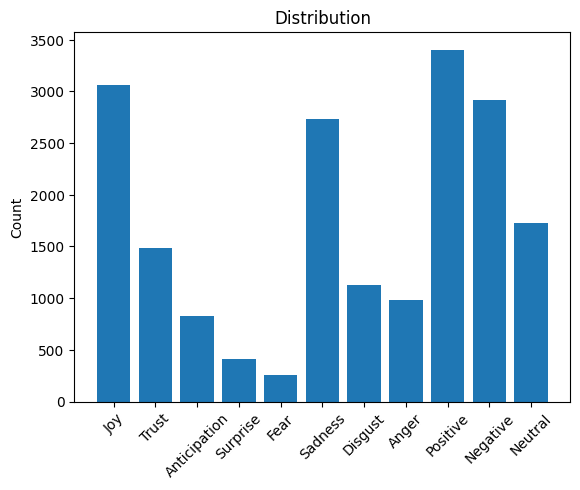

In [48]:
import matplotlib.pyplot as plt

counts = count_emotions(test_texts)

plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Distribution')
plt.show()

In [ ]:
train_texts.iloc[:, 769].sum()

np.int64(3063)

In [5]:
train_texts.head(10)

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,trust,anticipation,surprise,fear,sadness,disgust,anger,positive,negative,neutral
0,0.562764,-0.397882,-0.267292,-0.567739,-1.149851,0.662654,0.128688,0.475320,-0.341749,0.943553,...,0,0,1,0,1,0,1,0,1,0
1,-0.025572,-0.235864,-0.290113,-0.991783,-0.482610,-0.079471,-0.227736,-1.217292,0.438888,-0.221104,...,0,0,0,0,1,1,1,0,1,0
2,-0.475408,0.156776,-0.210054,-1.350016,-0.126225,-0.365511,0.108856,-0.143321,0.438478,0.077761,...,0,0,0,0,0,1,1,0,1,0
3,-0.336756,0.084884,-0.059477,-0.480968,0.186055,-1.020058,-0.095881,0.175767,-0.000036,0.103957,...,0,0,0,0,1,1,1,0,1,0
4,-0.477066,-0.384985,0.092087,-0.471120,-0.756108,-0.020734,-0.597373,-0.533785,0.817650,-0.484433,...,0,0,0,0,0,0,1,0,1,1
5,-0.496382,-0.243892,-0.093434,-0.223938,0.163552,-0.107771,-0.155038,-0.587985,-0.201445,0.310824,...,0,0,0,0,0,0,0,1,0,1
6,0.118517,0.140505,-0.107383,-0.213710,-0.135078,-0.422372,0.039289,-0.559245,-0.158402,-0.107544,...,0,0,0,0,0,0,0,1,0,1
7,0.097196,-0.078515,-0.249001,-0.379476,-0.063541,-0.161061,-0.200802,-0.974016,-0.269598,-0.232394,...,0,0,1,0,1,0,0,0,1,0
8,0.251442,0.039844,-0.041393,0.003911,0.021001,-0.140833,0.306735,0.057826,-0.162801,-0.397339,...,0,0,0,0,0,0,1,1,1,1
9,0.270282,0.079601,0.281395,-0.319867,0.225556,-0.520233,-0.212180,-0.398634,0.146555,-0.211571,...,0,0,0,0,0,0,1,0,1,0


In [6]:
train_sentences.head(10)

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,trust,anticipation,surprise,fear,sadness,disgust,anger,positive,negative,neutral
0,-0.107992,-0.544149,0.053766,-0.632760,-0.311535,-0.581503,-0.313330,-0.348168,0.349289,-0.406877,...,0,0,1,0,1,1,1,0,1,0
1,0.311132,-0.028671,0.441330,0.269969,-0.503570,-0.387672,0.084179,0.129839,0.064349,-0.002668,...,0,0,0,0,0,0,0,0,0,1
2,-0.059933,-0.061721,0.278209,-0.076590,-0.328901,-0.568747,0.589950,-0.501475,0.192955,-0.235708,...,0,0,0,0,0,0,0,1,0,1
3,-0.768429,0.329751,-0.046399,0.045369,-0.539526,-0.464502,0.219784,-0.005870,0.543218,0.019147,...,0,0,0,0,1,0,0,1,1,0
4,-0.079323,-0.283436,-0.049123,0.551994,-0.150095,-0.236103,-0.445485,0.063526,-0.037673,0.159559,...,1,0,0,0,0,0,0,1,0,0
5,0.008165,-0.044767,-0.019482,-0.543493,0.151010,-0.438446,-0.115624,-0.558962,-0.040636,-0.198771,...,0,0,0,0,1,0,1,0,1,0
6,0.192084,0.341302,0.191277,-0.035575,-0.619834,-0.517675,0.101253,-0.099043,-0.411317,-0.308393,...,0,1,0,0,0,0,0,1,0,0
7,-0.034829,-0.051287,0.388698,0.251668,-0.303737,-0.325470,-0.421632,0.267487,-0.006021,-0.086745,...,0,0,0,0,1,0,0,0,1,0
8,-0.085704,0.031369,0.434524,-0.142889,-0.652816,-0.535798,0.209822,-0.081895,-0.156835,-0.037204,...,1,1,0,0,0,0,0,1,0,1
9,0.134724,0.155525,0.143574,0.011912,-0.135043,-0.729203,-0.419711,-0.199815,-0.166667,0.060348,...,0,0,0,0,0,0,0,1,0,0


Przygotowanie danych wejściowych i walidacyjnych.

In [7]:
X_train_texts = train_texts.iloc[:, :768] # + train_sentences.iloc[:, :768]
y_train_texts = train_texts.iloc[:, 769:] # + train_sentences.iloc[:, 769:]

X_val_texts = val_texts.iloc[:, :768] # + val_sentences.iloc[:, :768]
y_val_texts = val_texts.iloc[:, 769:] # + val_sentences.iloc[:, 769:]

Budowa i konfiguracja sieci neuronowej. Model to klasyczny Sequential w Kerasie, złożony z kilku gęstych warstw (Dense), warstw normalizacyjnych (BatchNormalization) i warstw z odrzuceniem (Dropout). Na końcu mamy warstwę z aktywacją sigmoid, bo przewidujemy wiele etykiet naraz (multilabel classification).

In [70]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LayerNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_dim = X_train_texts.shape[1]
output_dim = y_train_texts.shape[1]

model = Sequential([
    Dense(1024, activation='relu', input_shape=(input_dim, )),
    BatchNormalization(),
    # LayerNormalization(),
    Dropout(0.4),
    
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    BatchNormalization(),
    # LayerNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    BatchNormalization(),
    # LayerNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    BatchNormalization(),
    # LayerNormalization(),
    Dropout(0.2),
    
    Dense(output_dim, activation='sigmoid')
])

c:\Users\mchoj\Documents\GitHub\emotion-and-sentiment-recognition\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tutaj określamy sposób optymalizacji modelu sieci neuronowej oraz metryki uywane do oceny jakości predykcji.

Optymalizator - algorytm Adam,który łączy zalety optymalizatorów AdaGrad oraz RMSProp +  mechanizm stopniowego wygaszania tempa;

Podczas treningu monitorowane są trzy metryki:

binary_accuracy – miara trafności klasyfikacji liczona oddzielnie dla każdej etykiety,

precision – precyzja, czyli stosunek liczby trafnie przewidzianych pozytywnych przykładów do wszystkich przewidzianych jako pozytywne,

recall – czułość, czyli stosunek trafnie wykrytych przykładów pozytywnych do wszystkich rzeczywistych pozytywnych przykładów.

Wszystkie metryki są liczone przy zastosowaniu progu 0.5 – oznacza to, że jeśli model zwróci prawdopodobieństwo ≥ 0.5 dla danej etykiety, to zostanie ono zinterpretowane jako 1.



In [71]:
from keras.metrics import Precision, Recall

optimizer = Adam(learning_rate=0.001, decay=1e-6)

model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=[
        'binary_accuracy',
        Precision(thresholds=0.5, name='precision'),
        Recall(thresholds=0.5, name='recall'),
    ]
)

c:\Users\mchoj\Documents\GitHub\emotion-and-sentiment-recognition\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Tu widać warstwa po warstwie, jak zbudowana jest nasza sieć. Zaczynamy od dużej warstwy z 1024 neuronami, potem stopniowo zmniejszamy liczbę neuronów aż do wyjścia z 11 predykcjami. Dodajemy BatchNormalization, żeby ustabilizować trening, i Dropout, żeby sieć się nie przeuczyła. Dzięki temu model jest dosyć głęboki, ale zabezpieczony przed zbyt dużym dopasowaniem do danych.

In [72]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,830,539 (6.98 MB)

 Trainable params: 1,826,699 (6.97 MB)

 Non-trainable params: 3,840 (15.00 KB)

Tutaj trenujemy naszą sieć neuronową. Mamy dwie techniki wspomagające trening: EarlyStopping, który przerywa uczenie, jeśli model się nie poprawia, i ReduceLROnPlateau, który automatycznie zmniejsza learning rate, kiedy model utknie. Trenujemy maksymalnie 16 epok, ale jeśli model wcześniej osiągnie optimum na danych walidacyjnych, trening się wcześniej zakończy.

In [73]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_texts, y_train_texts,
    epochs=16,
    batch_size=8,
    validation_data=(X_val_texts, y_val_texts),
    callbacks=[early_stop, reduce_lr],
)

Epoch 1/16
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - binary_accuracy: 0.7082 - loss: 0.5810 - precision: 0.4828 - recall: 0.5913 - val_binary_accuracy: 0.8475 - val_loss: 0.3604 - val_precision: 0.7896 - val_recall: 0.6193 - learning_rate: 0.0010
Epoch 2/16
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - binary_accuracy: 0.8373 - loss: 0.3766 - precision: 0.7519 - recall: 0.5972 - val_binary_accuracy: 0.8584 - val_loss: 0.3399 - val_precision: 0.7990 - val_recall: 0.6591 - learning_rate: 0.0010
Epoch 3/16
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - binary_accuracy: 0.8454 - loss: 0.3641 - precision: 0.7669 - recall: 0.6220 - val_binary_accuracy: 0.8598 - val_loss: 0.3353 - val_precision: 0.8008 - val_recall: 0.6633 - learning_rate: 0.0010
Epoch 4/16
800/800 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - binary_accuracy: 0.8472 - loss: 0.3563 - precision: 0.7644 - recall: 0.6335 - val_binary_accuracy: 0.8580 - val_loss: 0.3367 - val_precision: 0.7881 - val_recall: 0.6728 - learning_rate: 0.0010
Epo

In [74]:
model.save('../models/neural_network.keras') 

In [75]:
import keras

history = keras.models.load_model('../models/neural_network.keras')

Tutaj ręcznie liczymy klasyczne metryki klasyfikacji – precision, recall i F1 – dla każdej emocji osobno.  Obliczamy metryki indywidualne oraz średnią z wyników dla wszystkich etykiet. Dzięki temu możemy ocenić, jak dobrze model radzi sobie z każdą emocją z osobna.

In [76]:
import numpy as np
from typing import Dict

def evaluate_texts(model, X_test: pd.DataFrame, y_test: pd.DataFrame, threshold: float=0.5) -> Dict:
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > threshold).astype(int)
    
    y_test = y_test.values
    
    labels = ['Joy', 'Trust', 'Anticipation', 'Surprise', 'Fear', 'Sadness', 'Disgust', 'Anger', 'Positive', 'Negative', 'Neutral']
    metrics = {}
    
    metrics['F1-score macro texts'] = 0
    for label in labels:
        metrics[f"Precision {label}"] = 0
        metrics[f"Recall {label}"] = 0
        metrics[f"F1-score {label}"] = 0
        metrics[f"TP {label}"] = 0
        metrics[f"FP {label}"] = 0
        metrics[f"TN {label}"] = 0
        metrics[f"FN {label}"] = 0
    
    for i, label in enumerate(labels):
        metrics[f"TP {label}"] = int(np.sum((y_pred_binary[:, i] == 1) & (y_test[:, i] == 1)))
        metrics[f"FP {label}"] = int(np.sum((y_pred_binary[:, i] == 1) & (y_test[:, i] == 0)))
        metrics[f"TN {label}"] = int(np.sum((y_pred_binary[:, i] == 0) & (y_test[:, i] == 0)))
        metrics[f"FN {label}"] = int(np.sum((y_pred_binary[:, i] == 0) & (y_test[:, i] == 1)))
        
    for label in labels:
        metrics[f"Precision {label}"] = metrics[f"TP {label}"] / (metrics[f"TP {label}"] + metrics[f"FP {label}"] + 1e-8)
        metrics[f"Recall {label}"] = metrics[f"TP {label}"] / (metrics[f"TP {label}"] + metrics[f"FN {label}"] + 1e-8)
        metrics[f"F1-score {label}"] = 2 * (metrics[f"Precision {label}"] * metrics[f"Recall {label}"]) / (metrics[f"Precision {label}"] + metrics[f"Recall {label}"] + 1e-8)

    metrics['F1-score macro texts'] = sum(metrics[f"F1-score {label}"] for label in labels) / len(labels)
    
    metrics = {k: v for (k, v) in metrics.items() if ('Precision' in k) or ('Recall' in k) or ('F1' in k)}

    return metrics

In [77]:
def evaluate_sentences_v1(model, X_test: pd.DataFrame, y_test: pd.DataFrame, threshold: float=0.5) -> Dict:
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > threshold).astype(int)
    
    y_test = y_test.values
    
    labels = ['Joy', 'Trust', 'Anticipation', 'Surprise', 'Fear', 'Sadness', 'Disgust', 'Anger', 'Positive', 'Negative', 'Neutral']
    metrics = {}
    
    metrics['F1-score macro sentences'] = 0
    for label in labels:
        metrics[f"Precision {label}"] = 0
        metrics[f"Recall {label}"] = 0
        metrics[f"F1-score {label}"] = 0
        metrics[f"TP {label}"] = 0
        metrics[f"FP {label}"] = 0
        metrics[f"TN {label}"] = 0
        metrics[f"FN {label}"] = 0
    
    for i, label in enumerate(labels):
        metrics[f"TP {label}"] = int(np.sum((y_pred_binary[:, i] == 1) & (y_test[:, i] == 1)))
        metrics[f"FP {label}"] = int(np.sum((y_pred_binary[:, i] == 1) & (y_test[:, i] == 0)))
        metrics[f"TN {label}"] = int(np.sum((y_pred_binary[:, i] == 0) & (y_test[:, i] == 0)))
        metrics[f"FN {label}"] = int(np.sum((y_pred_binary[:, i] == 0) & (y_test[:, i] == 1)))
        
    for label in labels:
        metrics[f"Precision {label}"] = metrics[f"TP {label}"] / (metrics[f"TP {label}"] + metrics[f"FP {label}"] + 1e-8)
        metrics[f"Recall {label}"] = metrics[f"TP {label}"] / (metrics[f"TP {label}"] + metrics[f"FN {label}"] + 1e-8)
        metrics[f"F1-score {label}"] = 2 * (metrics[f"Precision {label}"] * metrics[f"Recall {label}"]) / (metrics[f"Precision {label}"] + metrics[f"Recall {label}"] + 1e-8)

    metrics['F1-score macro sentences'] = sum(metrics[f"F1-score {label}"] for label in labels) / len(labels)

    metrics = {k: v for (k, v) in metrics.items() if ('Precision' in k) or ('Recall' in k) or ('F1' in k)}

    return metrics


In [78]:
def get_hash_indeces(df: pd.DataFrame) -> List:
    hash_indices = []
    for index in df.index.tolist():
        if str(df.loc[index, 'text']).startswith('#'):
            hash_indices.append(index)
          
    result_hash_indices = []   
    i = 0
    for index in hash_indices:
        index = index - i
        result_hash_indices.append(index)
        i += 1
    
    return result_hash_indices

Ta funkcja ocenia model na poziomie całych recenzji. Dla każdej recenzji sumujemy przewidywane prawdopodobieństwa dla wszystkich jej zdań i sprawdzamy, które emocje były  przekroczyły zadany próg. Potem porównujemy te przewidywania z rzeczywistymi etykietami i liczymy metryki precision, recall i F1 osobno dla każdej emocji. 



In [79]:
def evaluate_sentences_v2(model: keras.Model, X_test: pd.DataFrame, y_test: pd.DataFrame, threshold: float=1): # -> Dict:
    raw_data = encode_labels(pd.read_csv('../data/raw/test.csv'))
    hash_indices = get_hash_indeces(raw_data)
    
    y_pred = model.predict(X_test)
    y_test = y_test.values
    
    labels = ['Joy', 'Trust', 'Anticipation', 'Surprise', 'Fear', 'Sadness', 'Disgust', 'Anger', 'Positive', 'Negative', 'Neutral']
    metrics = {}
    
    metrics['F1-score macro sentences'] = 0
    for label in labels:
        metrics[f"Precision {label}"] = 0
        metrics[f"Recall {label}"] = 0
        metrics[f"F1-score {label}"] = 0
        metrics[f"TP {label}"] = 0
        metrics[f"FP {label}"] = 0
        metrics[f"TN {label}"] = 0
        metrics[f"FN {label}"] = 0
    
    y_true_segments = []
    y_pred_segments = []
    
    i = 0
    start = 0
    for index in hash_indices:
        pred_sum = np.zeros(11, dtype=np.float64)
        for y_pred_i in y_pred[start:index]:
            pred_sum += y_pred_i
            
        y_true_segments.append(raw_data.iloc[index+0, 1:].to_numpy())
        y_pred_segments.append((pred_sum >= threshold).astype(int))
                    
        i += 1
        start = index

    y_true_segments = np.array(y_true_segments)
    y_pred_segments = np.array(y_pred_segments)

    for i, label in enumerate(labels):
        metrics[f"TP {label}"] = int(np.sum((y_pred_segments[:, i] == 1) & (y_true_segments[:, i] == 1)))
        metrics[f"FP {label}"] = int(np.sum((y_pred_segments[:, i] == 1) & (y_true_segments[:, i] == 0)))
        metrics[f"TN {label}"] = int(np.sum((y_pred_segments[:, i] == 0) & (y_true_segments[:, i] == 0)))
        metrics[f"FN {label}"] = int(np.sum((y_pred_segments[:, i] == 0) & (y_true_segments[:, i] == 1)))
        
    for label in labels:
        metrics[f"Precision {label}"] = metrics[f"TP {label}"] / (metrics[f"TP {label}"] + metrics[f"FP {label}"] + 1e-8)
        metrics[f"Recall {label}"] = metrics[f"TP {label}"] / (metrics[f"TP {label}"] + metrics[f"FN {label}"] + 1e-8)
        metrics[f"F1-score {label}"] = 2 * (metrics[f"Precision {label}"] * metrics[f"Recall {label}"]) / (metrics[f"Precision {label}"] + metrics[f"Recall {label}"] + 1e-8)

    metrics['F1-score macro sentences'] = sum(metrics[f"F1-score {label}"] for label in labels) / len(labels)

    metrics = {k: v for (k, v) in metrics.items() if ('Precision' in k) or ('Recall' in k) or ('F1' in k)}

    return metrics

In [80]:
texts_metrics = evaluate_texts(history, X_test=test_texts.iloc[:, :768], y_test=test_texts.iloc[:, 769:], threshold=0.5)
print(texts_metrics)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
{'F1-score macro texts': 0.5589679193423925, 'Precision Joy': 0.7999999999857142, 'Recall Joy': 0.8145454545306446, 'F1-score Joy': 0.8072072021930689, 'Precision Trust': 0.6936416184570149, 'Recall Trust': 0.5741626793983654, 'F1-score Trust': 0.6282722463204135, 'Precision Anticipation': 0.6458333331987847, 'Recall Anticipation': 0.24799999998016, 'F1-score Anticipation': 0.3583814988392529, 'Precision Surprise': 0.0, 'Recall Surprise': 0.0, 'F1-score Surprise': 0.0, 'Precision Fear': 0.6923076917751478, 'Recall Fear': 0.1525423728555013, 'F1-score Fear': 0.24999999697145062, 'Precision Sadness': 0.868978805378247, 'Recall Sadness': 0.8199999999850909, 'F1-score Sadness': 0.8437792279163885, 'Precision Disgust': 0.69599999994432, 'Recall Disgust': 0.3580246913432912, 'F1-score Disgust': 0.4728260824449138, 'Precision Anger': 0.8169014083356477, 'Recall Anger': 0.27619047617732423, 'F1-score Anger': 0.41281138409442636, 'Precision Positive': 0.77

In [81]:
sentences_metrics_v1 = evaluate_sentences_v1(history, X_test=test_sentences.iloc[:, :768], y_test=test_sentences.iloc[:, 769:], threshold=0.5)
print(sentences_metrics_v1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
{'F1-score macro sentences': 0.5880950400409627, 'Precision Joy': 0.7894736841274239, 'Recall Joy': 0.8720930231544078, 'F1-score Joy': 0.8287292766887457, 'Precision Trust': 0.695652173610586, 'Recall Trust': 0.5333333331555555, 'F1-score Trust': 0.603773579765041, 'Precision Anticipation': 0.9999999900000002, 'Recall Anticipation': 0.08333333326388888, 'F1-score Anticipation': 0.1538461521893491, 'Precision Surprise': 0.0, 'Recall Surprise': 0.0, 'F1-score Surprise': 0.0, 'Precision Fear': 0.571428570612245, 'Recall Fear': 0.3333333330555555, 'F1-score Fear': 0.42105262648199443, 'Precision Sadness': 0.8723404254391128, 'Recall Sadness': 0.9010989009998793, 'F1-score Sadness': 0.8864864813919651, 'Precision Disgust': 0.6285714283918368, 'Recall Disgust': 0.4888888887802469, 'F1-score Disgust': 0.5499999949406251, 'Precision Anger': 0.839999999664, 'Recall Anger': 0.46666666656296296, 'F1-score Anger': 0.5999999952367348, 'Precision Positive': 0.8

In [82]:
sentences_metrics_v2 = evaluate_sentences_v2(history, X_test=test_sentences.iloc[:, :768], y_test=test_sentences.iloc[:, 769:], threshold=0.5)
print(sentences_metrics_v2)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
{'F1-score macro sentences': 0.15919378981692603, 'Precision Joy': 0.4999999998076923, 'Recall Joy': 0.18309859152350727, 'F1-score Joy': 0.2680412331342332, 'Precision Trust': 0.21739130425330813, 'Recall Trust': 0.19999999992, 'F1-score Trust': 0.20833332825520845, 'Precision Anticipation': 0.04761904759637188, 'Recall Anticipation': 0.0624999999609375, 'F1-score Anticipation': 0.054054049116143615, 'Precision Surprise': 0.0999999999, 'Recall Surprise': 0.0999999999, 'F1-score Surprise': 0.09999999490000026, 'Precision Fear': 0.0, 'Recall Fear': 0.0, 'F1-score Fear': 0.0, 'Precision Sadness': 0.5185185183264746, 'Recall Sadness': 0.1794871794641683, 'F1-score Sadness': 0.26666666279546486, 'Precision Disgust': 0.12499999994791666, 'Recall Disgust': 0.09999999996666667, 'F1-score Disgust': 0.11111110613168747, 'Precision Anger': 0.14285714278911565, 'Recall Anger': 0.0909090908815427, 'F1-score Anger': 0.11111110631687264, 'Precision Positive': 0.

In [83]:
def calculate_final_score(text_metrics: Dict, sentences_metrics: Dict) -> float:
    return (text_metrics['F1-score macro texts'] + sentences_metrics['F1-score macro sentences']) / 2

In [84]:
calculate_final_score(texts_metrics, sentences_metrics_v1)

0.5735314796916776

In [85]:
calculate_final_score(texts_metrics, sentences_metrics_v2)

0.35908085457965927

Model najlepiej radzi sobie, gdy analizujemy emocje na poziomie pojedynczych zdań (wersja v1) lub całych recenzji.
Próba agregowania predykcji zdań z powrotem do poziomu recenzji (v2) wypada słabo, najpewniej dlatego, że sumowanie predykcji i próg 1 są zbyt wymagające.
Finalny F1 w najlepszym wariancie wynosi ~0.57, co jest przyzwoitym wynikiem w klasyfikacji wieloetykietowej na danych języka polskiego.